# Exploring the Mechanism of Action (MOA) of compounds by integrating bioactivities from ChEMBL and functional genomics resources
### For comments, suggestions and errors, plese contact me at: asegura@ebi.ac.uk

## Loading libraries

In [67]:
suppressMessages(library(dplyr))
suppressMessages(library(jsonlite))
suppressMessages(library(urltools))
suppressMessages(library(reticulate))
suppressMessages(library(purrr))
suppressMessages(library(DT))
suppressMessages(library(knitr))
suppressMessages(library(networkD3))
suppressMessages(library(clusterProfiler))
suppressMessages(library(ReactomePA))
suppressMessages(library(org.Hs.eg.db))
suppressMessages(library(visNetwork))
suppressMessages(library(heatmaply))
suppressMessages(library(heatmaply))
suppressMessages(library(XML))
suppressMessages(library(magick))
suppressMessages(library(tidyr))
source_python("make_matrix.py")
source_python("sub_struc.py")
source_python("query_struc.py")
target_ids <- read.csv("equils_target_chembl_uniprot_symbols.txt", sep = "\t", header = T, row.names = NULL, as.is = T)
meta_data_indications_final <- read.csv("meta_data_indications_final.txt", sep = "\t", header = T, row.names = NULL, as.is = T)

# Performing a similarity search using ChEMBL web services

## Step 1: Please provide a molecule in SMILES format

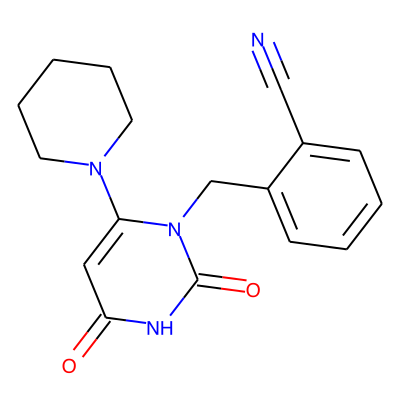

# A tibble: 1 x 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      400    400 sRGB       FALSE    19299 72x72  

In [8]:
my_compound <- "N#Cc1ccccc1Cn3c(N2CCCCC2)cc(=O)[nH]c3=O"
baseur_sim <- "https://www.ebi.ac.uk/chembl/api/data/similarity/"

simil_cut_off = "/85" # You should be able to modify the similarity treshold by modifying this number
pba <- fromJSON(paste0(baseur_sim, url_encode(my_compound), simil_cut_off, ".json?limit=50"), flatten=TRUE)

moltosvg(my_compound)

query_mol <- image_read("query_out.png")
query_mol

In [9]:
table_comp_match <- select(pba$molecules, molecule_chembl_id, similarity, molecule_properties.num_ro5_violations, withdrawn_flag, pref_name, molecule_structures.canonical_smiles)

colnames(table_comp_match) <- c("ChEMBL_ID","similarity",
                                "Ro5_violations","withdrawn_info","name","canonical_smiles")

table_comp_match$name <- ifelse(is.na(table_comp_match$name), table_comp_match$ChEMBL_ID, table_comp_match$name)

In [10]:
table_comp_match_final <- table_comp_match %>% 
  dplyr::mutate(ChEMBL_ID = paste0("<a target='_blank' href='https://www.ebi.ac.uk/chembl/beta/compound_report_card/",ChEMBL_ID,"'>",ChEMBL_ID,"</a>")) %>%
  datatable(escape = F, rownames = F, caption = "Similarity search results")

# Similarity search results

In [11]:
table_comp_match_final

HTML widgets cannot be represented in plain text (need html)

# Clustering analysis:
## Similarity all vs all

In [13]:
#Here we are calling a python function to create a similarity matrix by using Rdkit

py_df_simil <- make_matrix(table_comp_match,my_compound)

#Heatmap for visualizing the similarity relationships among compounds
d1 <- dist(py_df_simil, method = "manhattan", diag = FALSE, upper = TRUE)
d2 <- dist(t(py_df_simil), method = "manhattan", diag = FALSE, upper = TRUE)

c1 <- hclust(d1, method = "ward.D2", members = NULL)
c2 <- hclust(d2, method = "ward.D2", members = NULL)

heatmaply(as.matrix(py_df_simil), margins = c(60, 60, 0, 0),
          Rowv=as.dendrogram(c2), Colv=as.dendrogram(c1),
          colors = BrBG
          )

HTML widgets cannot be represented in plain text (need html)

# Are the compounds sharing a common sub-structure?

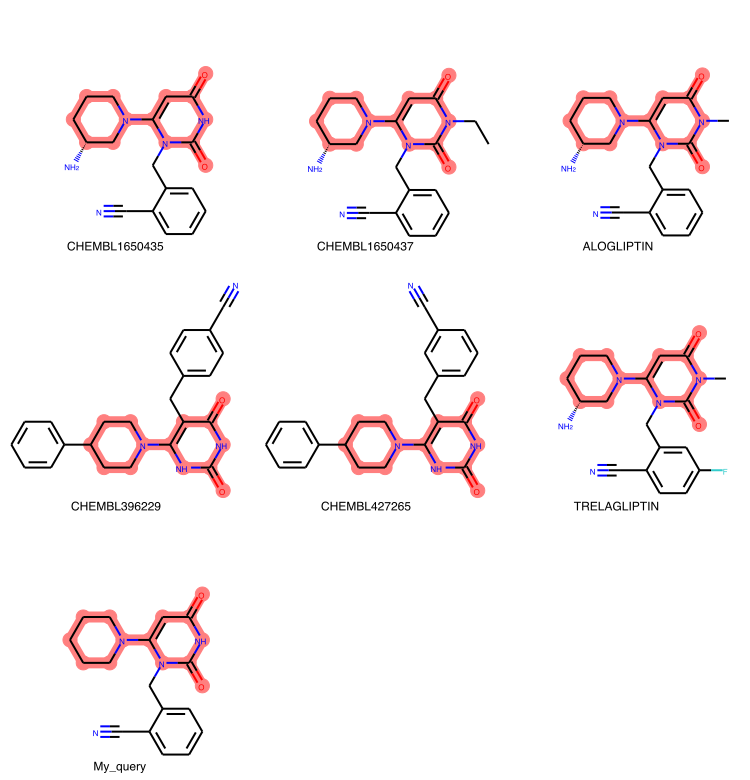

# A tibble: 1 x 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      750    780 sRGB       FALSE    96059 72x72  

In [18]:
#Here we are calling a python function to perform a common substructure analysis by using Rdkit

make_subst(table_comp_match,my_compound)
substr_mol <- image_read("substr_out.png")
substr_mol

# Is there any information about the mechanism of action (MOA) of these compounds in ChEMBL?

In [44]:
comp_indi <- unique(table_comp_match$name)

df_indi <- dplyr::filter(meta_data_indications_final, name %in% comp_indi)

if(dim(df_indi)[1] == 0) {
  print("No mechanism of action avaliable for these compounds!")
} else {
  df_indi$efo_id <- gsub(':','_', df_indi$efo_id)
  df_indi %>%
    dplyr::mutate(target_chembl_id = paste0("<a target='_blank' href='https://www.ebi.ac.uk/chembl/beta/target_report_card/",target_chembl_id,"'>",target_chembl_id,"</a>")) %>%
    dplyr::mutate(efo_id = paste0("<a target='_blank' href='https://www.ebi.ac.uk/efo/",url_encode(efo_id),"'>",efo_id,"</a>")) %>%
  datatable(escape = F, rownames = F, options = list(autoWidth = T,scrollX = "200px"),caption = "MOA information in ChEMBL")
    }

HTML widgets cannot be represented in plain text (need html)

# Extracting target bioactivities from Binding assays

In [28]:
baseur_act <- "https://www.ebi.ac.uk/chembl/api/data/activity.json?molecule_chembl_id="

len_ids <- length(unique(table_comp_match$ChEMBL_ID))
pba2 <- lapply(table_comp_match$ChEMBL_ID, function(x){
fromJSON(paste0(baseur_act, x, "&assay_type=B&standard_units=nM","&limit=1000"),flatten=TRUE)
})

columns_assays <- c("target_chembl_id", "target_pref_name", "molecule_pref_name","molecule_chembl_id","standard_value","standard_relation", "standard_units", "standard_type", "pchembl_value", "target_organism", "document_chembl_id", "potential_duplicate")
m2 <- lapply(1:len_ids, function(x) pba2[[x]]$activities)
m2 <- m2[lapply(m2,length)>0]
m <- map_df(m2, `[`, columns_assays)

m <- m[m$potential_duplicate == "FALSE",]
m$pchembl_value <- -log10((as.numeric(m$standard_value)/1000000000))
m$pchembl_value <- round(m$pchembl_value, 2)
m$molecule_pref_name <- ifelse(is.na(m$molecule_pref_name), m$molecule_chembl_id, m$molecule_pref_name)

target_bioacti <- select(m, target_chembl_id, target_pref_name, molecule_pref_name, standard_relation, standard_value, standard_units, standard_type, pchembl_value,target_organism, document_chembl_id)
target_bioacti_final <- merge(target_ids[,c(1,3)], target_bioacti, by ="target_chembl_id")


dplyr::mutate(target_bioacti_final,document_chembl_id = paste0("<a target='_blank' href='https://www.ebi.ac.uk/chembl/beta/document_report_card/",document_chembl_id,"'>",document_chembl_id,"</a>")) %>%
  datatable(escape = F, rownames = F, options = list(autoWidth = T,scrollX = "50px"),caption = "Target bioactivities result")

HTML widgets cannot be represented in plain text (need html)

# What are the main pathways being pertuberd by these compounds?
## Let's perform an enrichment analysis of Reactome pathways of the targets and their interacting partners obtained from STRING

In [40]:
string_api_url <- "https://string-db.org/api"
method <- "interaction_partners"
species <- "9606"
limit <- 20
my_app <- "www.awesome_app.org"

target_bioacti_final <- target_bioacti_final[target_bioacti_final$standard_relation == "=",]
my_genes <- paste(unique(target_bioacti_final$gene_symbol), collapse = "%0d")
  graph_chembl_final <- target_bioacti_final %>% group_by(molecule_pref_name, gene_symbol) %>% summarize(score= mean(pchembl_value))
  graph_chembl_final <- as.data.frame(graph_chembl_final)
  colnames(graph_chembl_final) <- c("col_A", "col_B", "score")
  graph_chembl_final$type <- "ChEMBL"
  
  string <- fromJSON(paste0(string_api_url, "/json", "/interaction_partners?","identifiers=", my_genes,"&species=",species,"&limit=",limit,"&caller_identity=",my_app), flatten = T)

  string <- string[string$escore >0,]

  my_ppis <- dplyr::select(string, preferredName_A, preferredName_B, escore)
  my_ppis$escore <- my_ppis$escore * 10
  colnames(my_ppis) <- c("col_A", "col_B", "score")
  my_ppis$type <- "PPI"
  ppi_chembl <- rbind(graph_chembl_final, my_ppis)
  symbol_ids <- unique(ppi_chembl$col_B)
  entrez_ids = bitr(symbol_ids, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")
  enrich <- enrichPathway(gene=entrez_ids$ENTREZID,pvalueCutoff=0.05, readable=T)
enrich_table <- as.data.frame(enrich)
enrich_table_exp <- enrich_table %>% transform(geneID = strsplit(geneID, "/")) %>% unnest(geneID)
enrich_table_exp <- enrich_table_exp[!duplicated(enrich_table_exp$geneID),]
enrich_table_exp$score <- -log(enrich_table_exp$p.adjust)
enrich_table_exp <- enrich_table_exp[,c(2,9,10)]
colnames(enrich_table_exp) <- c("col_A","col_B","score")
enrich_table_exp$type <- "Pathway"

'select()' returned 1:1 mapping between keys and columns


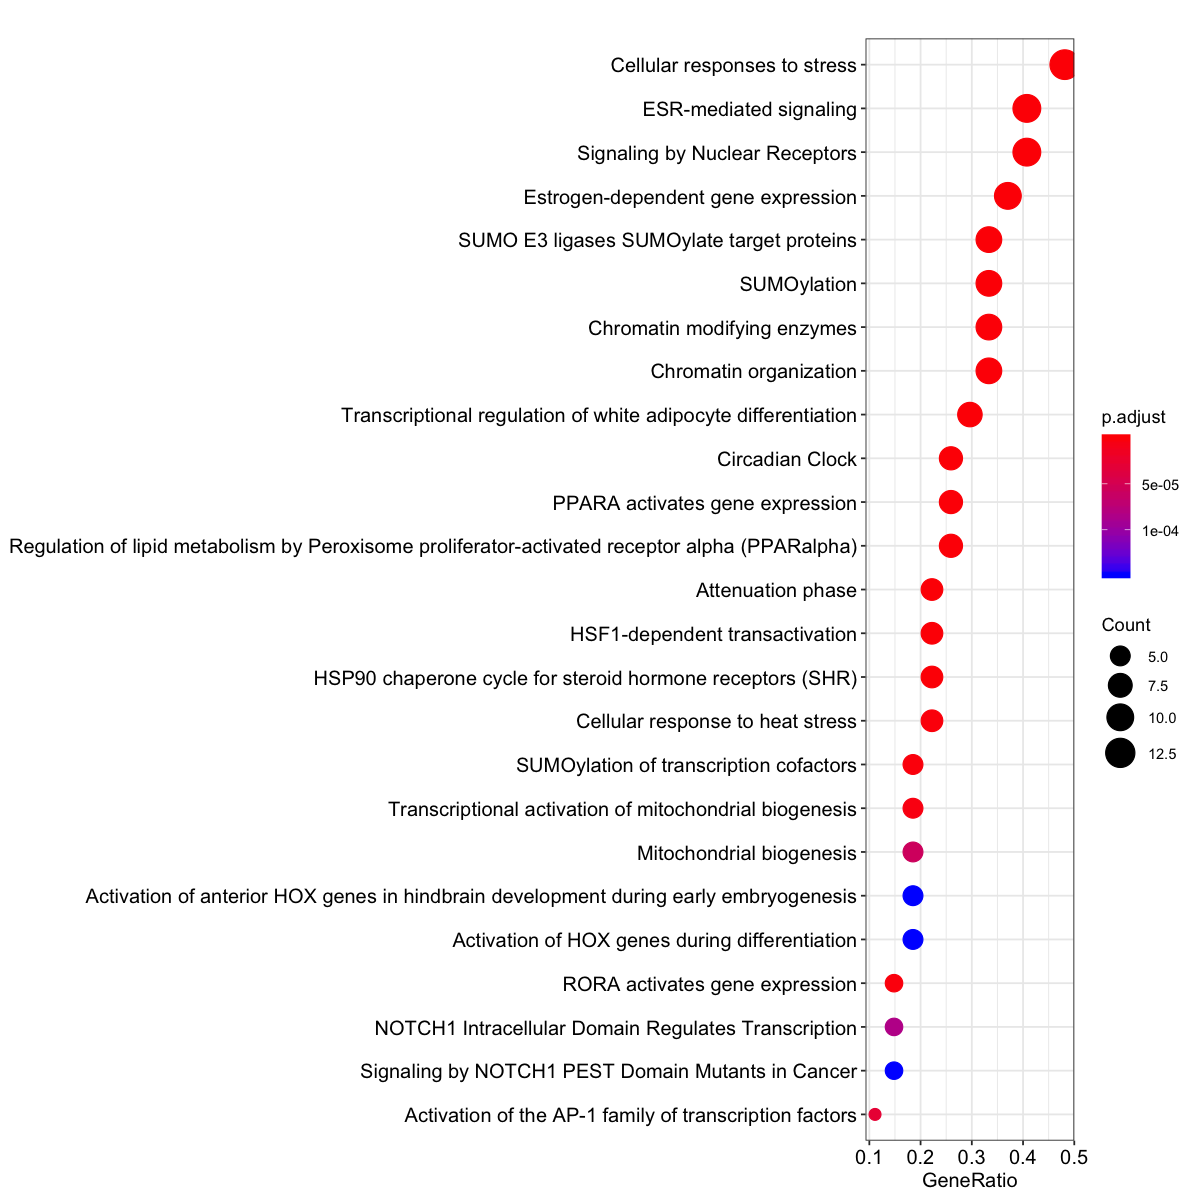

In [41]:
options(fig.align = "left",fig.height = 8, fig.width = 12, out.width = "100%", out.height= "100%")
enrichplot::dotplot(enrich, showCategory=25)

# Integrative visualization: 

In [64]:
indi_comp <- df_indi[,c(5,1)]
indi_comp <- indi_comp[!duplicated(indi_comp),]
colnames(indi_comp) <- c("col_A","col_B")
indi_comp$score <- 10
indi_comp$type <- "Indication"
indi_tar <- df_indi[,c(5,3)]
indi_tar <- indi_tar[!duplicated(indi_tar),]
colnames(indi_tar) <- c("col_A","col_B")
indi_tar$score <- 10
indi_tar$type <- "Indication"

meta_inte <- rbind(ppi_chembl, enrich_table_exp, indi_comp, indi_tar)
meta_inte$score <- round(meta_inte$score, 2) 

genes_A <- my_ppis %>% 
  dplyr::distinct(col_A) %>% 
  dplyr::rename(label = col_A)

genes_B <- my_ppis %>%
  dplyr::distinct(col_B) %>% 
  dplyr::rename(label = col_B)

genes_AB <- full_join(genes_A,genes_B, by = "label")

genes_AB$type <- "Gene"

comps <- graph_chembl_final[,c(1,4)]
comps <- comps[!duplicated(comps),]
names(comps)[1] <- "label" 


paths_AB <- enrich_table_exp[,c(1,4)]
paths_AB <- paths_AB[!duplicated(paths_AB),]
names(paths_AB)[1] <- "label"


indi_net <- unique(indi_comp[,c(1,4)])
names(indi_net)[1] <- "label"

labels_type <- rbind(indi_net,comps, genes_AB, paths_AB)
nodes <- labels_type %>%
  dplyr::mutate(id = 1:nrow(labels_type)) %>%
  dplyr::select(id, everything())

my_format <- data.frame(type = c("Indication","ChEMBL","Pathway","Gene"), shape = c("box","diamond","dot","square"))

nodes <- merge(nodes, my_format, by = "type")
nodes <- nodes[,c(2,3,1,4)]
names(nodes)[3] <- "group"
nodes <- nodes[order(nodes$group),]

edges <- meta_inte %>%
  dplyr::left_join(nodes[,1:2], by = c("col_A" = "label")) %>%
  dplyr::rename(from = id)
edges <- edges %>%
  dplyr::left_join(nodes[,1:2], by = c("col_B" = "label")) %>%
  dplyr::rename(to = id)
edges <- dplyr::select(edges, from, to, score)

nodes_d3 <- dplyr::mutate(nodes, id = id - 1)
nodes_d3 <- nodes_d3[order(nodes_d3$id),]

edges_d3 <- dplyr::mutate(edges, from = from - 1, to = to - 1)

# Integrative visualization: 
## Sankey Diagram
![](header_sankey.png)

In [66]:
sankeyNetwork(Links = edges_d3, Nodes = nodes_d3, Source = "from", Target = "to", Value = "score", NodeID = "label", NodeGroup = "group", units = "", fontSize = 15, nodeWidth = 35, height = 800, width = 1200, sinksRight = F)

HTML widgets cannot be represented in plain text (need html)

# Integrative visualization: 
## Interaction Network
![](header2.png)

In [63]:
visNetwork(nodes, edges, height = "800px",width = "100%") %>% 
  visGroups(groupname = "ChEMBL", color = "red") %>%
  visGroups(groupname = "Gene", color = "lightblue") %>%
  visGroups(groupname = "Indication", color = "yellow") %>%
  visGroups(groupname = "Pathway", color = "orange") %>%
  visOptions(highlightNearest = list(enabled =TRUE, degree = 2)) %>%
  visNodes(shadow = list(enabled = TRUE, size = 10))

HTML widgets cannot be represented in plain text (need html)